In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.font_manager as fm
import datetime
plt.style.use('seaborn')
sns.set(font_scale=1.5) 
warnings.filterwarnings('ignore')

# pd.set_option('display.max_rows', 10000)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
def encoding_function(data):
    DLY_code=pd.read_excel("Analysis분야_퓨처스리그_데이터설명서.xlsx", sheet_name="3) 지연결항코드")
    dic={}
    for i, j in DLY_code.iterrows():
        dic.update({j["코드"] : j["코드명"]})

    cleanup_nums = {"DRR": dic, "CNR" : dic}
    data.replace(cleanup_nums, inplace=True)

    return data

def make_port_list(data):
    ARP_list=data.ARP.unique().tolist()
    ODP_list=data.ODP.unique().tolist()
    ls=[]
    for i in ARP_list:
        for j in ODP_list:
                if i!=j:
                    ls.append((i,j))
    return ls

def total_elapsed_time_summary(data):
    AOD_A=data[data.AOD=="A"]
    AOD_D=data[data.AOD=="D"]
    df=pd.DataFrame(columns=["count", "mean", "std", "min", "25%", "50%", "75%", "max"])
    for i in make_port_list(data):

        port_d=i[0]
        port_a=i[1]

        airport_D=AOD_D[(AOD_D["ARP"]==port_d) &(AOD_D["ODP"]==port_a)].sort_values(by=["SDT"])
        airport_D.reset_index(drop=True, inplace=True)
        airport_D.drop(columns=['STT', 'ATT', 'differ'], axis=1, inplace=True)

        airport_A=AOD_A[(AOD_A["ARP"]==port_a) &(AOD_A["ODP"]==port_d)].sort_values(by=["SDT"])
        airport_A.reset_index(drop=True, inplace=True)
        airport_A.drop(columns=['STT', 'ATT', 'differ'], axis=1, inplace=True)

        airport_A["date"]=airport_A.SDT.apply(lambda x: datetime.datetime.date(x))
        airport_D["date"]=airport_D.SDT.apply(lambda x: datetime.datetime.date(x))

        table1=pd.merge(left=airport_D, right=airport_A, how='inner', on=['date', 'SDT_DY', 'FLO', 'FLT', 'REG'], suffixes=('_D', '_A'))
        table1.drop(columns=['ODP_D', 'ODP_A', 'AOD_A', 'AOD_D', 'IRR_D', 'IRR_A', 'DLY_D', 'DRR_D',\
                             'CNL_D', 'CNR_D', 'DLY_A','DRR_A', 'CNL_A', 'CNR_A'], axis=1, inplace=True)
        table1=table1[['date', 'SDT_DY', 'FLO', 'FLT', 'REG', 'ARP_D', 'ARP_A', 'SDT_D', 'SDT_A', 'ADT_D', 'ADT_A', 'count_D', 'count_A']]
        table1['SDT_differ']=table1['SDT_A']-table1['SDT_D']
        table1['ADT_differ']=table1['ADT_A']-table1['ADT_D']
        table1['ADT_differ']=table1['ADT_differ'].apply(lambda x: x.seconds//60) 
        table1['SDT_differ']=table1['SDT_differ'].apply(lambda x: x.seconds//60)
        df1=pd.DataFrame(table1['SDT_differ'].describe()).T
        df1.index=["{}_{}_계획시간(분)".format(port_d, port_a)]
        df2=pd.DataFrame(table1['ADT_differ'].describe()).T
        df2.index=["{}_{}_실운행시간(분)".format(port_d, port_a)]
        df=df.append([df1,df2])
    df.dropna(inplace=True)
    return df

def making_join_table(data):
    AOD_A=data[data.AOD=="A"]
    AOD_A["date"]=AOD_A.SDT.apply(lambda x: datetime.datetime.date(x))
    AOD_D=data[data.AOD=="D"]
    AOD_D["date"]=AOD_D.SDT.apply(lambda x: datetime.datetime.date(x))

    table=pd.merge(left=AOD_A, right=AOD_D, how='outer', on=['date','SDT_DY', 'FLO', 'FLT', 'REG'], suffixes=('_A', '_D'))
    table.drop(columns=['SDT_DY', 'ODP_A', 'AOD_A', 'STT_A', 'ATT_A', 'differ_A', 'date', 'ODP_D', 'AOD_D', \
                         'STT_D', 'ATT_D', 'differ_D'], axis=1, inplace=True)
    table=table[['FLO', 'FLT', 'REG', 'ARP_D', 'SDT_D', 'ADT_D', 'count_D', 'IRR_D', 'DLY_D', 'DRR_D', 'CNL_D', 'CNR_D', \
                 'ARP_A', 'SDT_A', 'ADT_A', 'count_A', 'IRR_A', 'DLY_A', 'DRR_A', 'CNL_A', 'CNR_A']]
    return table

def making_datetime(data):
    ######## test에도 동일하게 처리 해주어야 한다.
    data["SDT_MM"]=data["SDT_MM"].astype("str").apply(lambda x: x if len(x)==2 else "0"+x)
    data["SDT_DD"]=data["SDT_DD"].astype("str").apply(lambda x: x if len(x)==2 else "0"+x)
    
    data["SDT"]=data["SDT_YY"].apply(lambda x : str(x))+"-"+data["SDT_MM"]+"-"+data["SDT_DD"]+" "+data["STT"]
    data["SDT"]=pd.to_datetime(data["SDT"])
    
    if "ATT" in data.columns:
        data["ADT"]=data["SDT_YY"].apply(lambda x : str(x))+"-"+data["SDT_MM"]+"-"+data["SDT_DD"]+" "+data["ATT"]
        data["ADT"]=pd.to_datetime(data["ADT"])
        data["differ"]=data["ADT"]-data["SDT"]

    ############################################################################
    data.drop(columns=["SDT_YY", "SDT_MM", "SDT_DD"], axis=1, inplace=True)
    ############################################################################

    ######## test에도 동일하게 처리 해주어야 한다.
    # 각 공항별 시간대 항공기 운항 수 
    by_time_airport=data.groupby(by=["ARP", "SDT"]).size().reset_index(name="count")

    data=pd.merge(left=data, right=by_time_airport, how="left", left_on=["ARP", "SDT"], right_on=["ARP", "SDT"])
    data.count=data["count"]
    
    return data

def season_data_making_datetime(data):
    data.FSD=data.FSD.astype("str")
    data.FED=data.FED.astype("str")
    data.FSD=data.FSD.apply(lambda x : x[:4]+"-"+x[4:6]+"-"+x[6:])
    data.FED=data.FED.apply(lambda x : x[:4]+"-"+x[4:6]+"-"+x[6:])

    data["FSD_time"]=data["FSD"]+" "+data["STD"]
    data["FSD_time"]=pd.to_datetime(data["FSD_time"])
    data["FSD"]=pd.to_datetime(data["FSD"])
    data["FED"]=pd.to_datetime(data["FED"])
    data.drop(columns=["SSC", "STD", "STA", "MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"], axis=1, inplace=True)
    data["under_date"]="2019-09-16"
    data["over_date"]="2019-10-01"
    data["under_date"]=pd.to_datetime(data["under_date"])
    data["over_date"]=pd.to_datetime(data["over_date"])
    data=data[(data["under_date"] < data["FED"]) & (data["FSD"] < data["over_date"])]
    data.drop(columns=["under_date", "over_date"], axis=1, inplace=True)
    return data

## season data description (2019년 하계 스케줄 중 7월~9월이 포함된 시즌데이터)

| 컬럼 ID   | 컬럼명  | 설명 | 
|-----------|---------|------|
|  SSC  | 시즌코드  |       | 
|  FLT  | 편명  |       | 
|  ORG  |  공항 |       | 
| DES   |  상대공항  |       | 
| STD   | 출발시각  |       | 
| STA   | 도착시각  |       | 
| FLO   | 항공사  |       | 
| MON   | 월  |  Y일때 운항     | 
| TUE   | 화  |  Y일때 운항     | 
| WED   | 수  |  Y일때 운항     | 
| THU   | 목  |  Y일때 운항     | 
| FRI   | 금  |  Y일때 운항     | 
| SAT   | 토  |  Y일때 운항     | 
| SUN   | 일  |  Y일때 운항     | 
| FSD   | 시작일자  |       | 
| FED   | 종료일자  |       |
| IRR   | 부정기편  |       |


In [3]:
# 2017.01.01 ~ 2019.06.30 까지의 운항실적 데이터(학습데이터)
train_data = pd.read_csv("AFSNT.csv", encoding="CP949")
train_data = encoding_function(train_data)
# 2019년 하계 스케줄 중 7월~9월이 포함된 시즌데이터
season_data = pd.read_csv("SFSNT.csv", encoding="CP949")

# 2019.09.16 ~ 2019.09.30 까지 지연건수 및 지연확률 계산
test_data = pd.read_csv("AFSNT_DLY.csv", encoding="CP949")
test_data["ARP"][test_data.ARP=='`']="ARP1"

In [4]:
flo={"A" : "아시아나항공", "B" : "에어부산", "C" : "Unknown1", "D" : "Unknown2", "E" : "Unknown3", "F" : "이스타항공", "G" : "Unknown4",
     "H" : "제주항공", "I" : "진에어", "J" : "대한항공", "K" : "Unknown5", "L" : "티웨이항공", "M" : "코리아익스프레스에어"}

ARP={ "ARP1" : "서울/김포", "ARP2" : "부산/김해", "ARP3" : "제주", "ARP4" : "대구", "ARP5" : "울산", "ARP6" : "청주", "ARP7" : "무안", 
     "ARP8" : "광주", "ARP9" : "여수", "ARP10" : "양양", "ARP11" : "포항", "ARP12" : "사천", "ARP13" : "군산", "ARP14" : "횡성/원주",
     "ARP15" : "인천"}

# ICAO_code={"인천": "RKSI", "서울/김포": "RKSS", "제주" : "RKPC", "부산/김해" : "RKPK", "양양" : "RKNY", "횡성/원주" : "RKNW", 
#            "청주" : "RKTU", "대구" : "RKTN", "포항" : "RKTH", "광주" : "RKJJ", "무안" : "RKJB", "여수" : "RKJY", "울산" : "RKPU",
#            "사천" : "RKPS", "군산" : "RKJK"}

ICAO_code={"RKSI": "인천", "RKSS":"서울/김포", "RKPC":"제주", "RKPK":"부산/김해", "RKNY":"양양",  "RKNW":"횡성/원주", 
           "RKTU":"청주", "RKTN":"대구", "RKTH":"포항", "RKJJ":"광주", "RKJB":"무안", "RKJY":"여수", "RKPU":"울산",
           "RKPS":"사천", "RKJK": "군산"}

In [5]:
train_data.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN
4,2017,1,1,일,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


In [6]:
cleanup_nums = {"ARP" : ARP, "ODP" : ARP, "FLO" : flo}
train_data.replace(cleanup_nums, inplace=True)

cleanup_nums = {"ARP" : ARP, "ODP" : ARP, "FLO" : flo}
test_data.replace(cleanup_nums, inplace=True)

In [7]:
train_data.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN
4,2017,1,1,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


In [8]:
train_data=making_datetime(train_data)
test_data=making_datetime(test_data)

In [9]:
train_data.head()

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN,2017-01-01 09:30:00,2017-01-01 09:31:00,00:01:00,3
2,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN,2017-01-01 12:45:00,2017-01-01 13:03:00,00:18:00,2
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
4,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN,2017-01-01 16:10:00,2017-01-01 16:31:00,00:21:00,4


In [10]:
cleanup_nums = {"ORG" : ARP, "DES" : ARP, "FLO" : flo}
season_data.replace(cleanup_nums, inplace=True)

count라는 변수는 공항의 활주로에 계획된 시간이 동일한 건수를 세어 활주로의 복잡도를 나타내주는 변수로 생성해주었다. 아래 그림 처럼 최대 많은 9건일 경우를 제외하고는 비행기가 1대 증가할수록 지연될 확률이 높아진다.

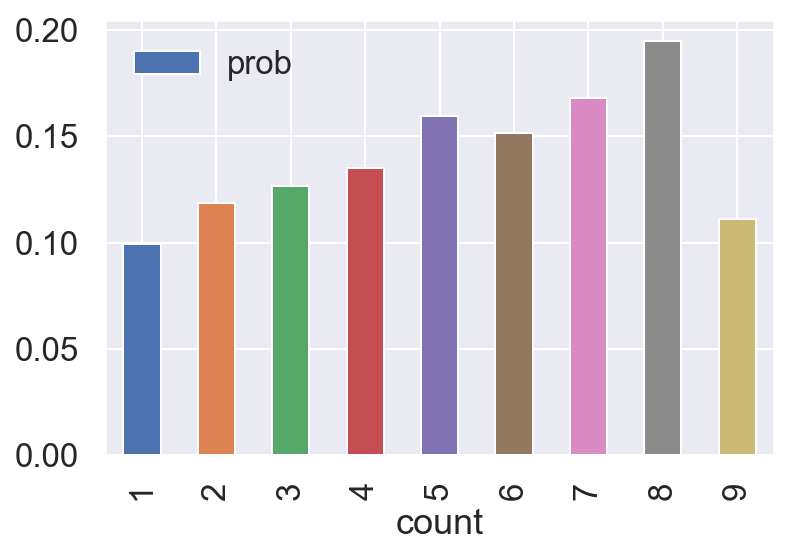

In [11]:
(train_data[train_data.DLY=="Y"].groupby(by=["count"]).size()/train_data.groupby(by=["count"]).size()).reset_index(name="prob").plot.bar(x="count", y="prob")

편명을 통해 유추할 수 있는 사실은 각 FLT(편명)의 앞글자는 항공사를 구별하는 식별자이고, 허나 뒤에 오는 숫자들은 노선을 의미하지는 않는 것 같다.

In [12]:
for airline in train_data.FLO.unique().tolist():
    print("{}의 FLT의 앞글자 : {}".format(airline ,set(train_data[train_data["FLO"]==airline]["FLT"].apply(lambda x : x[:1]))))

대한항공의 FLT의 앞글자 : {'J'}
에어부산의 FLT의 앞글자 : {'B'}
이스타항공의 FLT의 앞글자 : {'F'}
Unknown1의 FLT의 앞글자 : {'C'}
아시아나항공의 FLT의 앞글자 : {'A'}
제주항공의 FLT의 앞글자 : {'H'}
Unknown3의 FLT의 앞글자 : {'E'}
Unknown5의 FLT의 앞글자 : {'K'}
진에어의 FLT의 앞글자 : {'I'}
티웨이항공의 FLT의 앞글자 : {'L'}
Unknown4의 FLT의 앞글자 : {'G'}
Unknown2의 FLT의 앞글자 : {'D'}


### 아래 결과는 동일한 FLT를 가진다면 동일한 REG를 갖는지를 확인해 보기 위한 코드였는데 결과적으로는 가설이 맞지 않다.

- test data에서 REG가 없으므로 FLT를 통해 이전 공항 스케줄을 예측할 수 있는지 확인해 보아야한다.

In [15]:
season_data[season_data["FLT"]=="A1915"]

,SSC,FLT,ORG,DES,STD,STA,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED,IRR
0,S19,A1915,서울/김포,제주,7:55,9:05,아시아나항공,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N


In [16]:
train_data[train_data["FLT"]=="A1915"]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
200335,일,서울/김포,제주,아시아나항공,A1915,SEw3NTk0,D,N,10:10,11:38,Y,A/C 접속,N,NaN,2017-01-01 10:10:00,2017-01-01 11:38:00,01:28:00,1
200401,일,제주,서울/김포,아시아나항공,A1915,SEw3NTk0,A,N,11:15,12:24,Y,A/C 접속,N,NaN,2017-01-01 11:15:00,2017-01-01 12:24:00,01:09:00,1
200523,월,서울/김포,제주,아시아나항공,A1915,SEw4MjM2,D,N,10:10,10:33,N,NaN,N,NaN,2017-01-02 10:10:00,2017-01-02 10:33:00,00:23:00,1
200608,월,제주,서울/김포,아시아나항공,A1915,SEw4MjM2,A,N,11:15,11:30,N,NaN,N,NaN,2017-01-02 11:15:00,2017-01-02 11:30:00,00:15:00,1
200708,화,서울/김포,제주,아시아나항공,A1915,SEw3NzAz,D,N,10:10,10:27,N,NaN,N,NaN,2017-01-03 10:10:00,2017-01-03 10:27:00,00:17:00,1
200776,화,제주,서울/김포,아시아나항공,A1915,SEw3NzAz,A,N,11:15,11:17,N,NaN,N,NaN,2017-01-03 11:15:00,2017-01-03 11:17:00,00:02:00,1
200901,수,서울/김포,제주,아시아나항공,A1915,SEw3NzAz,D,N,10:10,10:27,N,NaN,N,NaN,2017-01-04 10:10:00,2017-01-04 10:27:00,00:17:00,1
200983,수,제주,서울/김포,아시아나항공,A1915,SEw3NzAz,A,N,11:15,11:22,N,NaN,N,NaN,2017-01-04 11:15:00,2017-01-04 11:22:00,00:07:00,1
201102,목,서울/김포,제주,아시아나항공,A1915,SEw3NTk0,D,N,10:10,10:23,N,NaN,N,NaN,2017-01-05 10:10:00,2017-01-05 10:23:00,00:13:00,1
201175,목,제주,서울/김포,아시아나항공,A1915,SEw3NTk0,A,N,11:15,11:16,N,NaN,N,NaN,2017-01-05 11:15:00,2017-01-05 11:16:00,00:01:00,1


### 결국 동일한 

In [17]:
season_data.head()

,SSC,FLT,ORG,DES,STD,STA,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED,IRR
0,S19,A1915,서울/김포,제주,7:55,9:05,아시아나항공,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N
1,S19,A1904,제주,서울/김포,7:55,9:05,아시아나항공,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N
2,S19,I1304,제주,서울/김포,8:00,9:15,진에어,Y,NaN,Y,Y,Y,NaN,Y,20190331,20191026,N
3,S19,B1802,부산/김해,서울/김포,8:00,8:55,에어부산,Y,Y,Y,Y,Y,Y,Y,20190331,20191026,N
4,S19,J1106,서울/김포,부산/김해,8:00,9:05,대한항공,NaN,Y,Y,NaN,Y,Y,NaN,20190730,20190824,N


In [18]:
season_dt=season_data_making_datetime(season_data)

In [19]:
season_dt.head()

,FLT,ORG,DES,FLO,FSD,FED,IRR,FSD_time
0,A1915,서울/김포,제주,아시아나항공,2019-03-31,2019-10-26,N,2019-03-31 07:55:00
1,A1904,제주,서울/김포,아시아나항공,2019-03-31,2019-10-26,N,2019-03-31 07:55:00
2,I1304,제주,서울/김포,진에어,2019-03-31,2019-10-26,N,2019-03-31 08:00:00
3,B1802,부산/김해,서울/김포,에어부산,2019-03-31,2019-10-26,N,2019-03-31 08:00:00
6,J1106,서울/김포,부산/김해,대한항공,2019-09-02,2019-10-17,N,2019-09-02 08:00:00


In [27]:
# 결과가 공집합이므로 위의 추려진 season data에 test data의 모든 항공 스케줄이 있다.
set(test_data.FLT.unique().tolist())-set(season_dt.FLT.unique().tolist())

set()

In [35]:
datetime.datetime.strptime("2019-09-20 00:00:00", "%Y-%m-%d %H:%M:%S")

datetime.datetime(2019, 9, 20, 0, 0)

In [42]:
airline_df=season_dt[season_dt["FLO"]=="대한항공"]

In [45]:
airline_df[airline_df.FED == datetime.datetime.strptime("2019-09-20 00:00:00", "%Y-%m-%d %H:%M:%S")]

,FLT,ORG,DES,FLO,FSD,FED,IRR,FSD_time
230,J1128,서울/김포,부산/김해,대한항공,2019-09-09,2019-09-20,N,2019-09-09 19:00:00
742,J1129,부산/김해,서울/김포,대한항공,2019-09-09,2019-09-20,N,2019-09-09 20:40:00


In [46]:
train_data[train_data["FLT"]=="J1128"]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
131,일,부산/김해,서울/김포,대한항공,J1128,SEw3NTY4,A,N,19:55,19:50,N,NaN,N,NaN,2017-01-01 19:55:00,2017-01-01 19:50:00,-1 days +23:55:00,2
245,일,서울/김포,부산/김해,대한항공,J1128,SEw3NTY4,D,N,19:00,19:12,N,NaN,N,NaN,2017-01-01 19:00:00,2017-01-01 19:12:00,00:12:00,4
487,월,부산/김해,서울/김포,대한항공,J1128,SEw4MjQ1,A,N,19:55,20:03,N,NaN,N,NaN,2017-01-02 19:55:00,2017-01-02 20:03:00,00:08:00,1
573,월,서울/김포,부산/김해,대한항공,J1128,SEw4MjQ1,D,N,19:00,19:19,N,NaN,N,NaN,2017-01-02 19:00:00,2017-01-02 19:19:00,00:19:00,4
705,화,부산/김해,서울/김포,대한항공,J1128,SEw3NzU3,A,N,19:55,19:48,N,NaN,N,NaN,2017-01-03 19:55:00,2017-01-03 19:48:00,-1 days +23:53:00,1
828,화,서울/김포,부산/김해,대한항공,J1128,SEw3NzU3,D,N,19:00,19:10,N,NaN,N,NaN,2017-01-03 19:00:00,2017-01-03 19:10:00,00:10:00,4
1068,수,부산/김해,서울/김포,대한항공,J1128,SEw3NTY2,A,N,19:55,19:59,N,NaN,N,NaN,2017-01-04 19:55:00,2017-01-04 19:59:00,00:04:00,2
1150,수,서울/김포,부산/김해,대한항공,J1128,SEw3NTY2,D,N,19:00,19:17,N,NaN,N,NaN,2017-01-04 19:00:00,2017-01-04 19:17:00,00:17:00,4
1318,목,부산/김해,서울/김포,대한항공,J1128,SEw3NTY4,A,N,19:55,20:10,N,NaN,N,NaN,2017-01-05 19:55:00,2017-01-05 20:10:00,00:15:00,1
1433,목,서울/김포,부산/김해,대한항공,J1128,SEw3NTY4,D,N,19:00,19:30,N,NaN,N,NaN,2017-01-05 19:00:00,2017-01-05 19:30:00,00:30:00,4


In [44]:
train_data[train_data.FLT=="J1955"].ARP.unique()
train_data[train_data.FLT=="J1955"].ODP.unique()

array(['제주', '청주'], dtype=object)

### `AOD == "D"` 이면 이전 스케줄의 도착 시간과 이번 스케줄의 출발시간의 차이를 구해야 하므로 `이전 스케줄의 ATT와 STT`

In [62]:
train_data[train_data.FLO=="코리아익스프레스에어"]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count


In [66]:
season_dt["time"]=season_dt.FSD_time.apply(lambda x : datetime.datetime.time(x))

In [68]:
season_dt[season_dt.FLO=="코리아익스프레스에어"].sort_values(by=["time"]) 

,FLT,ORG,DES,FLO,FSD,FED,IRR,FSD_time,time
716,M1361,양양,제주,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 09:30:00,09:30:00
718,M1361,양양,제주,코리아익스프레스에어,2019-04-04,2019-10-26,N,2019-04-04 09:30:00,09:30:00
717,M1361,양양,제주,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 09:50:00,09:50:00
719,M1361,양양,제주,코리아익스프레스에어,2019-04-04,2019-10-26,N,2019-04-04 09:50:00,09:50:00
759,M1361,양양,제주,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 10:00:00,10:00:00
760,M1361,양양,제주,코리아익스프레스에어,2019-04-04,2019-10-26,N,2019-04-04 10:00:00,10:00:00
940,M1351,양양,부산/김해,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 13:40:00,13:40:00
942,M1351,양양,부산/김해,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 13:55:00,13:55:00
943,M1351,양양,부산/김해,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 14:00:00,14:00:00
714,M1352,부산/김해,양양,코리아익스프레스에어,2019-04-01,2019-10-26,N,2019-04-01 15:05:00,15:05:00


In [73]:
train_data.head()

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN,2017-01-01 09:30:00,2017-01-01 09:31:00,00:01:00,3
2,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN,2017-01-01 12:45:00,2017-01-01 13:03:00,00:18:00,2
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
4,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN,2017-01-01 16:10:00,2017-01-01 16:31:00,00:21:00,4


In [76]:
train_data[(train_data.ARP=="양양") & (train_data.ODP=="제주")]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count


In [84]:
test_data

,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE,SDT,count
0,월,서울/김포,제주,티웨이항공,L1702,A,9:05,NaN,NaN,2019-09-16 09:05:00,2
1,월,제주,서울/김포,티웨이항공,L1702,D,7:55,NaN,NaN,2019-09-16 07:55:00,5
2,월,서울/김포,제주,티웨이항공,L1720,A,14:40,NaN,NaN,2019-09-16 14:40:00,5
3,월,제주,서울/김포,티웨이항공,L1720,D,13:30,NaN,NaN,2019-09-16 13:30:00,4
4,월,대구,제주,티웨이항공,L1808,A,20:10,NaN,NaN,2019-09-16 20:10:00,1
5,월,제주,대구,티웨이항공,L1808,D,19:10,NaN,NaN,2019-09-16 19:10:00,1
6,월,제주,여수,대한항공,J1934,A,16:00,NaN,NaN,2019-09-16 16:00:00,3
7,월,여수,제주,대한항공,J1934,D,15:00,NaN,NaN,2019-09-16 15:00:00,1
8,월,제주,서울/김포,티웨이항공,L1703,A,8:10,NaN,NaN,2019-09-16 08:10:00,3
9,월,서울/김포,제주,티웨이항공,L1703,D,7:00,NaN,NaN,2019-09-16 07:00:00,3


In [82]:
train_data[''].groupby(train_data['FLO']).apply(get_stats).unstack()

,count,max,mean,min
FLO,,,,
Unknown1,3.0,4.0,2.666667,2.0
Unknown2,2.0,5.0,4.000000,3.0
Unknown3,1.0,2.0,2.000000,2.0
Unknown4,1.0,5.0,5.000000,5.0
Unknown5,2.0,2.0,1.500000,1.0
대한항공,276447.0,9.0,2.349803,1.0
아시아나항공,177187.0,9.0,2.478901,1.0
에어부산,135235.0,9.0,2.268370,1.0
이스타항공,88110.0,9.0,2.794064,1.0


In [79]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
# global_stats = train_data['DEPARTURE_DELAY'].groupby(df['FLO']).apply(get_stats).unstack()
# global_stats = global_stats.sort_values('count')
# global_stats

In [70]:
test_data[test_data.FLO=="코리아익스프레스에어"]

,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE,SDT,count
86,월,제주,양양,코리아익스프레스에어,M1361,A,11:25,NaN,NaN,2019-09-16 11:25:00,2
87,월,양양,제주,코리아익스프레스에어,M1361,D,9:50,NaN,NaN,2019-09-16 09:50:00,1
92,월,제주,양양,코리아익스프레스에어,M1363,A,18:10,NaN,NaN,2019-09-16 18:10:00,2
93,월,양양,제주,코리아익스프레스에어,M1363,D,16:50,NaN,NaN,2019-09-16 16:50:00,1
193,월,부산/김해,양양,코리아익스프레스에어,M1351,A,14:30,NaN,NaN,2019-09-16 14:30:00,3
194,월,양양,부산/김해,코리아익스프레스에어,M1351,D,13:40,NaN,NaN,2019-09-16 13:40:00,1
197,월,양양,부산/김해,코리아익스프레스에어,M1352,A,16:05,NaN,NaN,2019-09-16 16:05:00,1
198,월,부산/김해,양양,코리아익스프레스에어,M1352,D,15:05,NaN,NaN,2019-09-16 15:05:00,2
1182,화,제주,양양,코리아익스프레스에어,M1361,A,11:25,NaN,NaN,2019-09-17 11:25:00,2
1183,화,양양,제주,코리아익스프레스에어,M1361,D,9:50,NaN,NaN,2019-09-17 09:50:00,1


In [67]:
season_dt[season_dt.FLO=="코리아익스프레스에어"]

,FLT,ORG,DES,FLO,FSD,FED,IRR,FSD_time,time
714,M1352,부산/김해,양양,코리아익스프레스에어,2019-04-01,2019-10-26,N,2019-04-01 15:05:00,15:05:00
715,M1352,부산/김해,양양,코리아익스프레스에어,2019-04-01,2019-10-26,N,2019-04-01 15:30:00,15:30:00
716,M1361,양양,제주,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 09:30:00,09:30:00
717,M1361,양양,제주,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 09:50:00,09:50:00
718,M1361,양양,제주,코리아익스프레스에어,2019-04-04,2019-10-26,N,2019-04-04 09:30:00,09:30:00
719,M1361,양양,제주,코리아익스프레스에어,2019-04-04,2019-10-26,N,2019-04-04 09:50:00,09:50:00
758,M1352,부산/김해,양양,코리아익스프레스에어,2019-04-01,2019-10-26,N,2019-04-01 15:25:00,15:25:00
759,M1361,양양,제주,코리아익스프레스에어,2019-03-31,2019-10-26,N,2019-03-31 10:00:00,10:00:00
760,M1361,양양,제주,코리아익스프레스에어,2019-04-04,2019-10-26,N,2019-04-04 10:00:00,10:00:00
808,M1363,양양,제주,코리아익스프레스에어,2019-09-01,2019-10-26,N,2019-09-01 16:50:00,16:50:00


In [45]:
train_data[]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN,2017-01-01 09:30:00,2017-01-01 09:31:00,00:01:00,3
2,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN,2017-01-01 12:45:00,2017-01-01 13:03:00,00:18:00,2
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
4,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN,2017-01-01 16:10:00,2017-01-01 16:31:00,00:21:00,4


In [39]:
train_data.FLT.unique().tolist()

['J1955',
 'J1954',
 'J1956',
 'J1957',
 'J1958',
 'J1959',
 'J1960',
 'J1961',
 'J1015',
 'J1242',
 'J1257',
 'J1220',
 'J1203',
 'J1813',
 'J1814',
 'J1254',
 'J1021',
 'J1235',
 'J1258',
 'J1236',
 'J1248',
 'J1909',
 'J1908',
 'J1806',
 'J1855',
 'J1854',
 'J1835',
 'J1219',
 'J1253',
 'J1834',
 'J1246',
 'J1247',
 'J1905',
 'J1904',
 'J1907',
 'J1204',
 'J1255',
 'J1237',
 'J1223',
 'J1239',
 'J1805',
 'J1808',
 'J1906',
 'J1825',
 'J1824',
 'J1935',
 'J1266',
 'J1260',
 'J1934',
 'J1268',
 'J1225',
 'J1921',
 'J1920',
 'J1903',
 'J1912',
 'J1006',
 'J1241',
 'J1244',
 'J1217',
 'J1245',
 'J1226',
 'J1229',
 'J1234',
 'J1216',
 'J1213',
 'J1240',
 'J1243',
 'J1222',
 'J1224',
 'J1231',
 'J1212',
 'J1227',
 'J1017',
 'J1014',
 'J1011',
 'J1218',
 'J1208',
 'J1207',
 'J1221',
 'J1230',
 'J1010',
 'J1020',
 'J1023',
 'J1215',
 'J1249',
 'J1205',
 'J1911',
 'J1206',
 'J1211',
 'J1209',
 'J1811',
 'J1910',
 'J1228',
 'J1214',
 'J1004',
 'J1005',
 'J1012',
 'J1210',
 'J1251',
 'J1250',


In [38]:
len(season_data.FLT.unique().tolist())

621

In [55]:
train_data[]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN,2017-01-01 09:30:00,2017-01-01 09:31:00,00:01:00,3
2,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN,2017-01-01 12:45:00,2017-01-01 13:03:00,00:18:00,2
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
4,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN,2017-01-01 16:10:00,2017-01-01 16:31:00,00:21:00,4
5,일,제주,청주,대한항공,J1959,SEw3NTk5,D,N,16:45,17:21,Y,A/C 접속,N,NaN,2017-01-01 16:45:00,2017-01-01 17:21:00,00:36:00,4
6,일,제주,청주,대한항공,J1960,SEw3NTk5,A,N,19:30,19:43,N,NaN,N,NaN,2017-01-01 19:30:00,2017-01-01 19:43:00,00:13:00,4
7,일,제주,청주,대한항공,J1961,SEw3NTk5,D,N,20:35,20:52,N,NaN,N,NaN,2017-01-01 20:35:00,2017-01-01 20:52:00,00:17:00,4
8,일,부산/김해,제주,대한항공,J1015,SEw3NzA2,A,N,17:05,17:03,N,NaN,N,NaN,2017-01-01 17:05:00,2017-01-01 17:03:00,-1 days +23:58:00,3
9,일,서울/김포,제주,대한항공,J1242,SEw3NzA2,D,N,20:25,20:36,N,NaN,N,NaN,2017-01-01 20:25:00,2017-01-01 20:36:00,00:11:00,3


In [44]:
merge_dt=pd.merge(left=season_dt, right=train_data, how="left", left_on=["FSD_time", "FLT", "ORG", "DES", "FLO"], \
         right_on=["SDT", "FLT", "ARP", "ODP", "FLO"])
merge_dt

,FLT,ORG,DES,FLO,FSD,FED,IRR_x,FSD_time,under_date,over_date,...,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,A1915,서울/김포,제주,아시아나항공,2019-03-31,2019-10-26,N,2019-03-31 07:55:00,2019-09-16,2019-10-01,...,7:55,8:01,N,NaN,N,NaN,2019-03-31 07:55:00,2019-03-31 08:01:00,00:06:00,1.0
1,A1904,제주,서울/김포,아시아나항공,2019-03-31,2019-10-26,N,2019-03-31 07:55:00,2019-09-16,2019-10-01,...,7:55,8:04,N,NaN,N,NaN,2019-03-31 07:55:00,2019-03-31 08:04:00,00:09:00,5.0
2,I1304,제주,서울/김포,진에어,2019-03-31,2019-10-26,N,2019-03-31 08:00:00,2019-09-16,2019-10-01,...,8:00,8:13,N,NaN,N,NaN,2019-03-31 08:00:00,2019-03-31 08:13:00,00:13:00,6.0
3,B1802,부산/김해,서울/김포,에어부산,2019-03-31,2019-10-26,N,2019-03-31 08:00:00,2019-09-16,2019-10-01,...,8:00,8:22,N,NaN,N,NaN,2019-03-31 08:00:00,2019-03-31 08:22:00,00:22:00,2.0
4,J1106,서울/김포,부산/김해,대한항공,2019-09-02,2019-10-17,N,2019-09-02 08:00:00,2019-09-16,2019-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN
5,J1106,서울/김포,부산/김해,대한항공,2019-08-27,2019-10-20,N,2019-08-27 08:00:00,2019-09-16,2019-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN
6,J1208,서울/김포,제주,대한항공,2019-03-31,2019-10-26,N,2019-03-31 08:00:00,2019-09-16,2019-10-01,...,8:00,8:15,N,NaN,N,NaN,2019-03-31 08:00:00,2019-03-31 08:15:00,00:15:00,2.0
7,I1304,제주,서울/김포,진에어,2019-03-31,2019-10-26,N,2019-03-31 08:05:00,2019-09-16,2019-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN
8,J1209,제주,서울/김포,대한항공,2019-04-06,2019-10-26,N,2019-04-06 08:10:00,2019-09-16,2019-10-01,...,8:10,8:24,N,NaN,N,NaN,2019-04-06 08:10:00,2019-04-06 08:24:00,00:14:00,4.0
9,F1207,서울/김포,제주,이스타항공,2019-03-31,2019-10-26,N,2019-03-31 08:10:00,2019-09-16,2019-10-01,...,8:10,9:26,Y,A/C 접속,N,NaN,2019-03-31 08:10:00,2019-03-31 09:26:00,01:16:00,2.0


In [46]:
merge_dt.columns

Index(['FLT', 'ORG', 'DES', 'FLO', 'FSD', 'FED', 'IRR_x', 'FSD_time',
       'under_date', 'over_date', 'SDT_DY', 'ARP', 'ODP', 'REG', 'AOD',
       'IRR_y', 'STT', 'ATT', 'DLY', 'DRR', 'CNL', 'CNR', 'SDT', 'ADT',
       'differ', 'count'],
      dtype='object')

In [21]:
train_data.head()

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN,2017-01-01 09:30:00,2017-01-01 09:31:00,00:01:00,3
2,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN,2017-01-01 12:45:00,2017-01-01 13:03:00,00:18:00,2
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
4,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN,2017-01-01 16:10:00,2017-01-01 16:31:00,00:21:00,4


In [29]:
season_data.head()

,SSC,FLT,ORG,DES,STD,STA,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED,IRR,FSD_time
0,S19,A1915,서울/김포,제주,7:55,9:05,아시아나항공,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N,2019-03-31 7:55
1,S19,A1904,제주,서울/김포,7:55,9:05,아시아나항공,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N,2019-03-31 7:55
2,S19,I1304,제주,서울/김포,8:00,9:15,진에어,Y,NaN,Y,Y,Y,NaN,Y,2019-03-31,2019-10-26,N,2019-03-31 8:00
3,S19,B1802,부산/김해,서울/김포,8:00,8:55,에어부산,Y,Y,Y,Y,Y,Y,Y,2019-03-31,2019-10-26,N,2019-03-31 8:00
4,S19,J1106,서울/김포,부산/김해,8:00,9:05,대한항공,NaN,Y,Y,NaN,Y,Y,NaN,2019-07-30,2019-08-24,N,2019-07-30 8:00


In [86]:
AOD_D=train_data[train_data.AOD=="D"]
AOD_A=train_data[train_data.AOD=="A"]

In [125]:
(train_data.ATT.apply(lambda x : x.split(":")[0]).astype("int") * 60 + train_data.ATT.apply(lambda x : x.split(":")[1]).astype("int")) - (train_data.STT.apply(lambda x : x.split(":")[0]).astype("int") * 60 + train_data.STT.apply(lambda x : x.split(":")[1]).astype("int"))

0         27
1          1
2         18
3         44
4         21
5         36
6         13
7         17
8         -2
9         11
10         4
11        16
12        -2
13        -9
14        10
15        19
16        -6
17        34
18        13
19        10
20        16
21        10
22        33
23        20
24        -1
25        10
26        -2
27         8
28        -1
29         8
          ..
987679    14
987680    13
987681    -7
987682   -12
987683    15
987684    31
987685    27
987686    13
987687    -9
987688    13
987689    12
987690    36
987691   -17
987692    10
987693    18
987694     2
987695    24
987696     9
987697   -14
987698    23
987699   -16
987700    10
987701    30
987702    -6
987703    14
987704    43
987705    24
987706   -10
987707     2
987708     9
Length: 987709, dtype: int64

In [110]:
train_data

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
1,일,제주,청주,대한항공,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN,2017-01-01 09:30:00,2017-01-01 09:31:00,00:01:00,3
2,일,제주,청주,대한항공,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN,2017-01-01 12:45:00,2017-01-01 13:03:00,00:18:00,2
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
4,일,제주,청주,대한항공,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN,2017-01-01 16:10:00,2017-01-01 16:31:00,00:21:00,4
5,일,제주,청주,대한항공,J1959,SEw3NTk5,D,N,16:45,17:21,Y,A/C 접속,N,NaN,2017-01-01 16:45:00,2017-01-01 17:21:00,00:36:00,4
6,일,제주,청주,대한항공,J1960,SEw3NTk5,A,N,19:30,19:43,N,NaN,N,NaN,2017-01-01 19:30:00,2017-01-01 19:43:00,00:13:00,4
7,일,제주,청주,대한항공,J1961,SEw3NTk5,D,N,20:35,20:52,N,NaN,N,NaN,2017-01-01 20:35:00,2017-01-01 20:52:00,00:17:00,4
8,일,부산/김해,제주,대한항공,J1015,SEw3NzA2,A,N,17:05,17:03,N,NaN,N,NaN,2017-01-01 17:05:00,2017-01-01 17:03:00,-1 days +23:58:00,3
9,일,서울/김포,제주,대한항공,J1242,SEw3NzA2,D,N,20:25,20:36,N,NaN,N,NaN,2017-01-01 20:25:00,2017-01-01 20:36:00,00:11:00,3


In [98]:
train_data[train_data.SDT>train_data.ADT]

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
8,일,부산/김해,제주,대한항공,J1015,SEw3NzA2,A,N,17:05,17:03,N,NaN,N,NaN,2017-01-01 17:05:00,2017-01-01 17:03:00,-1 days +23:58:00,3
12,일,서울/김포,제주,대한항공,J1203,SEw3NzA4,A,N,8:05,8:03,N,NaN,N,NaN,2017-01-01 08:05:00,2017-01-01 08:03:00,-1 days +23:58:00,2
13,일,대구,제주,대한항공,J1813,SEw3NzA4,A,N,17:45,17:36,N,NaN,N,NaN,2017-01-01 17:45:00,2017-01-01 17:36:00,-1 days +23:51:00,1
16,일,부산/김해,제주,대한항공,J1021,SEw3NzA4,A,N,21:05,20:59,N,NaN,N,NaN,2017-01-01 21:05:00,2017-01-01 20:59:00,-1 days +23:54:00,3
24,일,횡성/원주,제주,대한항공,J1855,SEw4MjQx,A,N,12:15,12:14,N,NaN,N,NaN,2017-01-01 12:15:00,2017-01-01 12:14:00,-1 days +23:59:00,1
26,일,사천,제주,대한항공,J1835,SEw4MjQx,A,N,16:15,16:13,N,NaN,N,NaN,2017-01-01 16:15:00,2017-01-01 16:13:00,-1 days +23:58:00,1
28,일,서울/김포,제주,대한항공,J1253,SEw3NzE2,A,N,8:15,8:14,N,NaN,N,NaN,2017-01-01 08:15:00,2017-01-01 08:14:00,-1 days +23:59:00,2
36,일,광주,제주,대한항공,J1905,SEw3Nzg1,A,N,9:20,9:15,N,NaN,N,NaN,2017-01-01 09:20:00,2017-01-01 09:15:00,-1 days +23:55:00,2
40,일,서울/김포,제주,대한항공,J1255,SEw3NTY5,A,N,11:55,11:52,N,NaN,N,NaN,2017-01-01 11:55:00,2017-01-01 11:52:00,-1 days +23:57:00,3
45,일,대구,제주,대한항공,J1805,SEw3NzE5,A,N,10:50,10:44,N,NaN,N,NaN,2017-01-01 10:50:00,2017-01-01 10:44:00,-1 days +23:54:00,1


In [87]:
AOD_D

,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,SDT,ADT,differ,count
0,일,제주,청주,대한항공,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN,2017-01-01 10:05:00,2017-01-01 10:32:00,00:27:00,4
3,일,제주,청주,대한항공,J1957,SEw3NzE4,D,N,13:25,14:09,Y,A/C 접속,N,NaN,2017-01-01 13:25:00,2017-01-01 14:09:00,00:44:00,4
5,일,제주,청주,대한항공,J1959,SEw3NTk5,D,N,16:45,17:21,Y,A/C 접속,N,NaN,2017-01-01 16:45:00,2017-01-01 17:21:00,00:36:00,4
7,일,제주,청주,대한항공,J1961,SEw3NTk5,D,N,20:35,20:52,N,NaN,N,NaN,2017-01-01 20:35:00,2017-01-01 20:52:00,00:17:00,4
9,일,서울/김포,제주,대한항공,J1242,SEw3NzA2,D,N,20:25,20:36,N,NaN,N,NaN,2017-01-01 20:25:00,2017-01-01 20:36:00,00:11:00,3
11,일,서울/김포,제주,대한항공,J1220,SEw3NzA4,D,N,13:25,13:41,N,NaN,N,NaN,2017-01-01 13:25:00,2017-01-01 13:41:00,00:16:00,3
14,일,대구,제주,대한항공,J1814,SEw3NzA4,D,N,18:25,18:35,N,NaN,N,NaN,2017-01-01 18:25:00,2017-01-01 18:35:00,00:10:00,2
15,일,서울/김포,제주,대한항공,J1254,SEw3NzA4,D,N,9:05,9:24,N,NaN,N,NaN,2017-01-01 09:05:00,2017-01-01 09:24:00,00:19:00,4
18,일,서울/김포,제주,대한항공,J1258,SEw3NTY2,D,N,11:30,11:43,N,NaN,N,NaN,2017-01-01 11:30:00,2017-01-01 11:43:00,00:13:00,4
19,일,서울/김포,제주,대한항공,J1236,SEw3NzE2,D,N,13:15,13:25,N,NaN,N,NaN,2017-01-01 13:15:00,2017-01-01 13:25:00,00:10:00,2
